## __Plato Notebook 3: Slab pull optimisation__

Thomas Schouten, Whitney Behr, Edward Clennett, Thorsten Becker


#### __0. Prepare Python__

First, we load the required packages.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib import cm
import gplately

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.optimisation import Optimisation
from plato.plate_torques import PlateTorques
from plato.plot import PlotReconstruction
from plato.slabs import Slabs
from plato.grids import Grids

#### __1. Set up the PlateTorques object__

The below cell loads a `PlateTorques` object for the Müller et al. (2016) reconstruction by providing the ages of interest and the relevant reconstruction files from the sample data folder.

In [2]:
# Plate reconstruction
reconstruction_name = "Muller2016" 

ages = np.arange(0, 201, 1)

# Set directory with sample data
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "sample_data", "M2016"))

# Set directory with supplementary data
suppl_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "supplementary_data"))

# Set directory to save the results
results_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "output_notebooks", "04c-Slab_pull_optimisation"))

# Set directory to save the figures
figs_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "figures_notebooks", "04c-Slab_pull_optimisation"))

# Load seafloor ages
seafloor_age_grids = {}; continental_grids = {}
for age in ages:
    file_path = os.path.join(data_dir, "seafloor_age_grids", f"M2016_SeafloorAgeGrid_{age}Ma.nc")
    if os.path.exists(file_path):
        seafloor_age_grids[age] = xr.open_dataset(file_path)
    else:
        seafloor_age_grids[age] = None

# Plotting parameters
cm2in = 0.3937008
fig_width = 18*cm2in*2; fig_height_graphs = 8*cm2in*2; fig_height_maps = 10.5*cm2in*2
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Arial"
title_fontsize = 18
plot_times = [45, 60, 75, 90]
projection = ccrs.Robinson(central_longitude = 160) 
annotations = ["a", "b", "c", "d"]

In [3]:
# Load reveal
reveal = xr.open_dataset(os.path.join(suppl_dir, "REVEAL_anomaly.nc"))

# Load Heuret et al. (2012) data
trench_sediment_thickness = pd.read_excel(os.path.join(data_dir, "present_day_sediments", "Heuret2012_data.xlsx"))

# Load GlobSed
globsed = xr.open_dataset(os.path.join(data_dir, "present_day_sediments", "GlobSed-v3.nc"))

In [4]:
# Set up PlateTorques objects
M2016 = PlateTorques(
    reconstruction_name = "Muller2016",
    ages = [0],
    files_dir = results_dir,
    rotation_file = os.path.join(data_dir, "gplates_files", "M2016_rotations_Lr-Hb.rot"),
    topology_file = os.path.join(data_dir, "gplates_files", "M2016_topologies.gpml"),
    polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
    seafloor_age_grids = seafloor_age_grids,
)

Calculating RMS velocities: 100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


In [5]:
M2016_slabs = Slabs(
    reconstruction_name = "Muller2016",
    ages = ages,
    files_dir = results_dir,
    rotation_file = os.path.join(data_dir, "gplates_files", "M2016_rotations_Lr-Hb.rot"),
    topology_file = os.path.join(data_dir, "gplates_files", "M2016_topologies.gpml"),
    polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
)

Loading slab data: 100%|██████████| 201/201 [00:01<00:00, 190.38it/s]


In [6]:
M2016_seafloor_grids = Grids(
    reconstruction_name = "Muller2016",
    ages = ages,
    files_dir = results_dir,
    rotation_file = os.path.join(data_dir, "gplates_files", "M2016_rotations_Lr-Hb.rot"),
    topology_file = os.path.join(data_dir, "gplates_files", "M2016_topologies.gpml"),
    polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
    seafloor_age_grids = seafloor_age_grids,
)

Loading grids: 100%|██████████| 201/201 [01:37<00:00,  2.05it/s]


#### __2. Sampling__

The below cell calls the `sample_slab_seafloor_ages` method of the `PlateTorques` object to sample seafloor ages at subduction zones and grid points.

In [7]:
M2016_slabs.sample_slab_seafloor_ages(grids = M2016_seafloor_grids.seafloor_age)

Sampling slabs:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling slabs: 100%|██████████| 1/1 [01:25<00:00, 85.16s/it]


In [8]:
M2016_slabs.calculate_slab_pull_force()

Calculating slab pull forces: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


#### __3. Calculation of slab flux__

The below cells initialise an `Optimisation` object, that contains methods to optimise the free parameters in the plate torque balance, using the `PlateTorques` object.

Then

In [9]:
M2016_slabs.calculate_velocities()

Calculating velocities at slabs: 100%|██████████| 201/201 [00:20<00:00,  9.59it/s]


In [10]:
# Save all data if the torques have been computed
M2016_slabs.save()

Saving Slabs: 100%|██████████| 201/201 [00:01<00:00, 130.92it/s]


In [11]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of points on Earth.

    :param lat1:    Latitude of the first point in degrees.
    :type lat1:     float
    :param lon1:    Longitude of the first point in degrees.
    :type lon1:     float
    :param lat2:    Latitude of the second point in degrees.
    :type lat2:     float
    :param lon2:    Longitude of the second point in degrees.
    :type lon2:     float

    :return:        The Haversine distance between the two points.
    :rtype:         float
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return c

In [12]:
for age in M2016.ages:
    for i, _ in enumerate(M2016.slabs.data[age]["ref"].lat):
        distance_to_segments = haversine(
            M2016.slabs.data[age]["ref"].loc[i, "lat"],
            M2016.slabs.data[age]["ref"].loc[i, "lon"],
            trench_sediment_thickness.Latitude,
            trench_sediment_thickness.Longitude
        )
        M2016.slabs.data[age]["ref"].loc[i, "sediment_thickness"] = trench_sediment_thickness["Sediment thickness"][distance_to_segments.idxmin()] * 1e3

M2016.options["ref"]["Active margin sediments"] = True

In [13]:
M2016.grids.sediment[0] = globsed

M2016.options["ref"]["Sample sediment grid"] = "z"

In [14]:
# Calculate slab flux on a 5x5 grid
lats = []; lons = []; fluxes = []
for age in M2016_slabs.ages:
    # Select data
    slab_data = M2016_slabs.data[age]["ref"]

    # Calculate thicknesses
    

    slab_flux = (slab_data.slab_lithospheric_thickness + slab_data.slab_crustal_thickness) * slab_data.convergence_velocity_mag/1e2 * slab_data.trench_segment_length * 1e6

    # Append values
    lats.extend(slab_data.lat.values); lons.extend(slab_data.lon.values); fluxes.extend(slab_flux)

In [15]:
plot_M2016 = PlotReconstruction(M2016, coastline_file=os.path.join(data_dir, "gplates_files", "M2016_coastlines.gpml"))

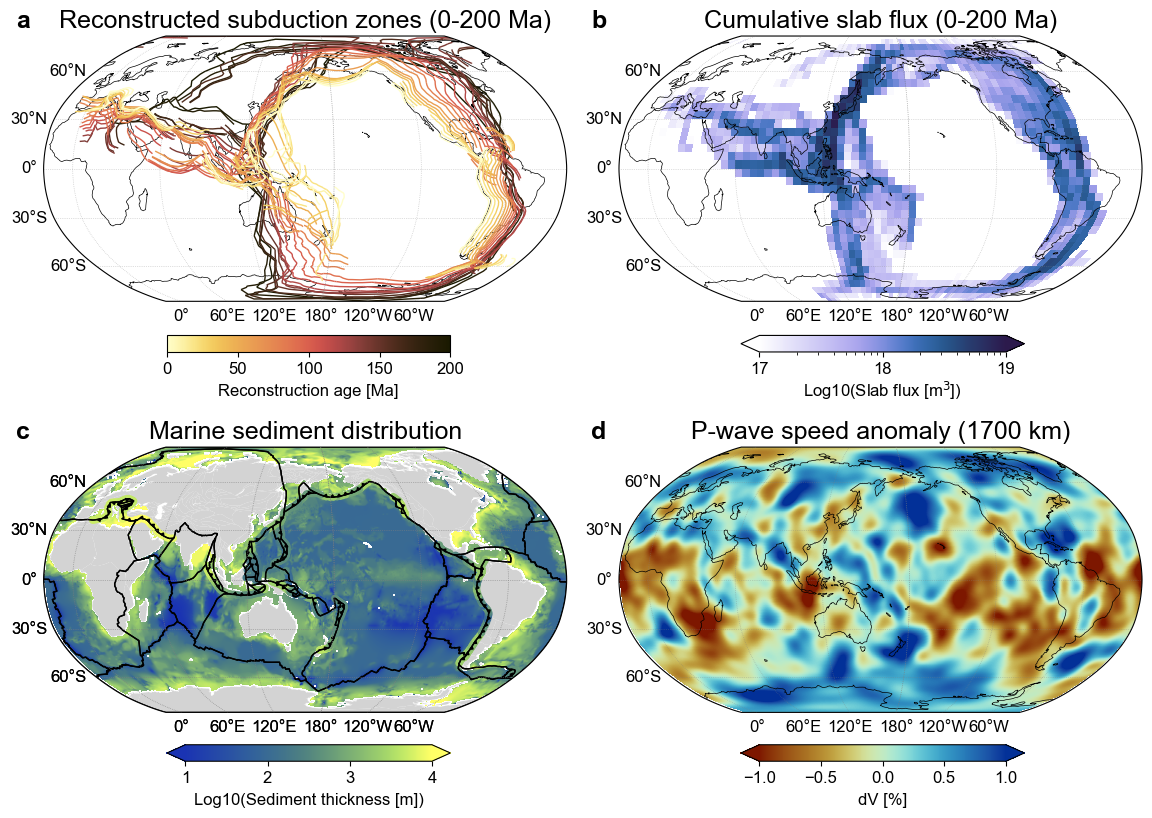

In [16]:
fig = plt.figure(figsize=(fig_width, 11.3*cm2in*2))
gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.5)

plot_titles = ["Reconstructed subduction zones (0-200 Ma)", "Cumulative slab flux (0-200 Ma)", "Marine sediment distribution", "P-wave speed anomaly (1700 km)"]

reconstruction_ages = np.arange(0, 201, 10)
colours = plt.get_cmap("cmc.lajolla")(np.linspace(0, 1, len(reconstruction_ages)))
gplot = gplately.PlotTopologies(plot_M2016.reconstruction)

# Plot slab pull constant along trenches for each case
m = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j], projection=projection)
        gl = plot_M2016.plot_basemap(ax)

        if m != 2:
            ax.coastlines(lw=0.5)

        ax.set_title(plot_titles[m], fontsize=title_fontsize)

        if m == 0:
            ax.imshow(np.ones_like(globsed.z), extent=[-180, 180, 90, -90], transform=ccrs.PlateCarree(), cmap="cmc.grayC", vmin=0, vmax=1)
            for k, age in enumerate(np.flip(reconstruction_ages)):
                gplot.update_time(age)
                trenches = gplot.plot_trenches(ax, lw=1, color=colours[k])

        if m == 1:
            h = ax.hist2d(
                lons, lats, bins=[72, 36], cmap="cmc.devon_r",
                weights=fluxes, transform=ccrs.PlateCarree(), norm=mcolors.LogNorm(vmin=1e16, vmax=1e18)
            )

        if m == 2:
            thicknesses = plot_M2016.plot_sediment_map(ax, 0, "ref", vmin=1e1)
            
        if m == 3:
            vp = ax.imshow(reveal.sel(depth=1700, method="nearest").vp_anomaly, extent=[-180, 180, 90, -90], transform=ccrs.PlateCarree(), cmap="cmc.roma", vmin=-1, vmax=1)

        ax.annotate(annotations[m], xy=(-0.053, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize) 
        ax.set_global()

        m += 1

# Create a ScalarMappable for the colourbar
norm = Normalize(vmin=reconstruction_ages[0], vmax=reconstruction_ages[-1])
sm = cm.ScalarMappable(cmap="cmc.lajolla_r", norm=norm)
sm.set_array([])

# Create new grids for the colourbars
cax1 = fig.add_axes([0.212, 0.52, 0.2, 0.02*(10.5/11.3)])
cax2 = fig.add_axes([0.617, 0.52, 0.2, 0.02*(10.5/11.3)])
cax3 = fig.add_axes([0.212, 0.06, 0.2, 0.02*(10.5/11.3)])
cax4 = fig.add_axes([0.617, 0.06, 0.2, 0.02*(10.5/11.3)])

# # Create a colorbar below the subplots
cbar1 = plt.colorbar(sm, cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(h[3], cax=cax2, orientation="horizontal", extend="both", extendfrac=7.5e-2)
cbar3 = plt.colorbar(thicknesses[0], cax=cax3, orientation="horizontal", extend="both", extendfrac=7.5e-2)
cbar4 = plt.colorbar(vp, cax=cax4, orientation="horizontal", extend="both", extendfrac=7.5e-2)

# # Set colorbar label
cbar1.set_label("Reconstruction age [Ma]", labelpad=5)
cbar2.set_label("Log10(Slab flux [m$^3$])", labelpad=1.5)
cbar2.set_ticklabels([16, 17, 18, 19])
cbar3.set_label("Log10(Sediment thickness [m])", labelpad=5)
cbar4.set_label("dV [%]", labelpad=5)

fig.savefig(os.path.join(figs_dir, f"M2016_subduction_REVEAL_mantle.png"), bbox_inches="tight", dpi=300)